# PROJECT CODE:

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)

In [ ]:
import numpy as np
import math
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import LabelEncoder


def calcInfo(df, attribute, cls):
    everyPossibleValue = df[attribute].unique()
    valueCounts = df[attribute].value_counts().to_dict()
    valueToEntropy = {}
    for value in everyPossibleValue:
        rowsOnlyWithVal = df[df[attribute] == value]
        classProbs = rowsOnlyWithVal[cls].value_counts() / len(rowsOnlyWithVal)
        entropy = 0
        for classProb in classProbs:
            entropy += classProb * np.log2(classProb)
        if entropy != 0:
            entropy *= -1
        valueToEntropy[value] = entropy
    return valueToEntropy


def calcInfoOfD(df, cls):
    classProbs = df[cls].value_counts() / len(df)
    entropy = 0
    for classProb in classProbs:
        entropy += classProb * np.log2(classProb)
    return entropy * -1


def calcSplitInfo(df, attribute):
    valueCounts = df[attribute].value_counts()
    totalRows = len(df)
    splitInfo = 0
    for count in valueCounts:
        probability = count / totalRows
        splitInfo -= probability * np.log2(probability)
    return splitInfo
def hybridDecisionTree(df, cls, max_depth=3, min_samples_for_nb=10, nb_threshold=0.7, depth=0, use_naive_bayes=True, category_ranges=None):
    if len(df[cls].unique()) == 1:
        return df[cls].iloc[0]

    elif depth >= max_depth or len(df.columns) <= 1:
        return df[cls].mode()[0]

    if use_naive_bayes and len(df) >= min_samples_for_nb:
        X = df[df.columns.difference([cls])]
        y = df[cls]

        gnb = CategoricalNB(min_categories=[len(category_ranges[col]) for col in X.columns])
        gnb.fit(X, y)

        probs = gnb.predict_proba(X)
        confidence = np.max(probs, axis=1).mean()

        if confidence >= nb_threshold:
            #print("returning nb")
            return {
                "model": gnb,
                "features": X.columns.tolist(),
                "category_ranges": {col: category_ranges[col] for col in X.columns}
            }

    entropyD = calcInfoOfD(df, cls)
    gains = {}

    for attribute in df.columns[:-1]:
        infosPerValue = calcInfo(df, attribute, cls)
        valueToProbability = {value: len(df[df[attribute] == value]) / len(df) for value in df[attribute].unique()}
        infoA = 0
        for value in valueToProbability:
            infoA += valueToProbability[value] * infosPerValue[value]
        gain = entropyD - infoA

        splitInfo = calcSplitInfo(df, attribute)
        gainRatio = gain / splitInfo if splitInfo != 0 else 0
        gains[attribute] = gainRatio

    maxGain = max(gains, key=gains.get)
    tree = {maxGain: {}}
    maxGainValues = df[maxGain].unique()

    for value in maxGainValues:
        rowsWithVal = df[df[maxGain] == value]
        columnsExceptMaxGain = [col for col in df.columns if col != maxGain]
        subset = rowsWithVal[columnsExceptMaxGain]

        subtree = hybridDecisionTree(
            subset,
            cls,
            max_depth,
            min_samples_for_nb,
            nb_threshold,
            depth + 1,
            use_naive_bayes,
            category_ranges
        )
        tree[maxGain][value] = subtree

    return tree

def predict_tree(instance, tr, use_naive_bayes=True, nb_threshold=0.7):
    if isinstance(tr, dict):  #decision tree logic
        if "model" in tr:  #naive bayes model
            gnb = tr["model"]
            features = tr["features"]
            return gnb.predict(instance[features].values.reshape(1, -1))[0]
        else:  #decision tree
            attribute = list(tr.keys())[0]
            value = instance[attribute]

            if isinstance(tr[attribute], str):
                return tr[attribute]

            if value not in tr[attribute]:
                subtree_classes = []
                for branch in tr[attribute].values():
                    if isinstance(branch, dict):
                        subtree_classes.extend(branch.keys())
                    else:
                        subtree_classes.append(branch)
                return max(set(subtree_classes), key=subtree_classes.count)
            else:
                subtree = tr[attribute][value]
            return predict_tree(instance, subtree, use_naive_bayes, nb_threshold)
    else:
        return tr


def accuracy(testing, tr, use_naive_bayes=True, nb_threshold=0.7):
    correct = 0
    for i, instance in testing.iterrows():
        prediction = predict_tree(instance, tr, use_naive_bayes, nb_threshold)
        if prediction == instance.iloc[-1]:
            correct += 1
    return correct / len(testing)

from sklearn.preprocessing import LabelEncoder

def run_decision_tree(df, cls, test_size=0.2, max_depth=30, min_samples_for_nb=10, use_naive_bayes=True, nb_threshold=0.7):
    df_encoded = df.copy()
    encoders = {col: LabelEncoder() for col in df.columns}

    category_ranges = {}
    for col in df.columns:
        df_encoded[col] = encoders[col].fit_transform(df[col])
        category_ranges[col] = range(len(encoders[col].classes_))

    train_data, test_data = train_test_split(df_encoded, test_size=test_size, random_state=42)

    decision_tree_model = hybridDecisionTree(
        train_data,
        cls,
        max_depth=max_depth,
        min_samples_for_nb=min_samples_for_nb,
        use_naive_bayes=use_naive_bayes,
        nb_threshold=nb_threshold,
        category_ranges=category_ranges
    )

    acc = accuracy(test_data, decision_tree_model, use_naive_bayes=use_naive_bayes, nb_threshold=nb_threshold)

    return decision_tree_model, acc, encoders


def predict_proba_tree(instance, tr, class_labels):

    if isinstance(tr, dict):
        if "model" in tr:
            gnb = tr["model"]
            features = tr["features"]
            probs = gnb.predict_proba(instance[features].values.reshape(1, -1))[0]
            return dict(zip(class_labels, probs))
        else:
            attribute = list(tr.keys())[0]
            value = instance[attribute]

            if value not in tr[attribute]:
                return {cls: 1.0 / len(class_labels) for cls in class_labels}

            subtree = tr[attribute][value]
            return predict_proba_tree(instance, subtree, class_labels)

    else:
        return {cls: 1.0 if cls == tr else 0.0 for cls in class_labels}




# RUNNING ON BUYS COMPUTER

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
import numpy as np

data = {
    "age": ["<=30","<=30", "31-40",">40", ">40", ">40", "31-40", "<=30", "<=30","31-40", ">40", "31-40", "<=30",">40"],
    "income": ["high","high", "high", "medium","low" , "low", "low", "medium", "low","medium", "medium", "medium","high","medium"],
    "student": ["no","no"  , "no","no", "yes", "yes", "yes", "no", "yes", "yes", "yes","no", "yes", "no"],
    "credit_rating": ["fair", "excellent", "fair", "fair", "fair", "excellent", "excellent", "fair","fair", "excellent","fair", "excellent","fair","excellent"],
    "buys_computer": ["no","no","yes","yes","yes","no", "yes","no", "yes", "yes", "yes", "yes","yes", "no"]
}

df = pd.DataFrame(data)

encoders = {col: LabelEncoder().fit(df[col]) for col in df.columns}
df_encoded = df.apply(lambda col: encoders[col.name].transform(col))

cls = "buys_computer"

train_data, test_data = train_test_split(df_encoded, test_size=0.2, random_state=42)

X_train = train_data.drop(columns=[cls])
y_train = train_data[cls]
X_test = test_data.drop(columns=[cls])
y_test = test_data[cls]

nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)
nb_acc = nb_model.score(X_test, y_test)

#print("regular decision tree:")
decision_tree_model, tree_acc,encoders = run_decision_tree(df, cls=cls, test_size=0.2, max_depth=3, min_samples_for_nb = 2,use_naive_bayes=False)
#print("Accuracy: ", tree_acc, "\n")


#print("hybrid tree")
hybrid_tree_model, hybrid_acc,encoders= run_decision_tree(df, cls=cls, test_size=0.2, max_depth=3, min_samples_for_nb = 2,use_naive_bayes=True, nb_threshold=0.85)
#print("Accuracy: ", hybrid_acc, "\n")

print("Naive Bayes Accuracy: ", nb_acc)
print("Decision Tree Accuracy: ", tree_acc)
print("Hybrid Model Accuracy: ", hybrid_acc)

Naive Bayes Accuracy:  0.3333333333333333
Decision Tree Accuracy:  1.0
Hybrid Model Accuracy:  1.0


In [ ]:
df

,age,income,student,credit_rating,buys_computer
0,<=30,high,no,fair,no
1,<=30,high,no,excellent,no
2,31-40,high,no,fair,yes
3,>40,medium,no,fair,yes
4,>40,low,yes,fair,yes
5,>40,low,yes,excellent,no
6,31-40,low,yes,excellent,yes
7,<=30,medium,no,fair,no
8,<=30,low,yes,fair,yes
9,31-40,medium,yes,excellent,yes


# RUNNING ON CONTRACEPTIVE METHOD DATASET

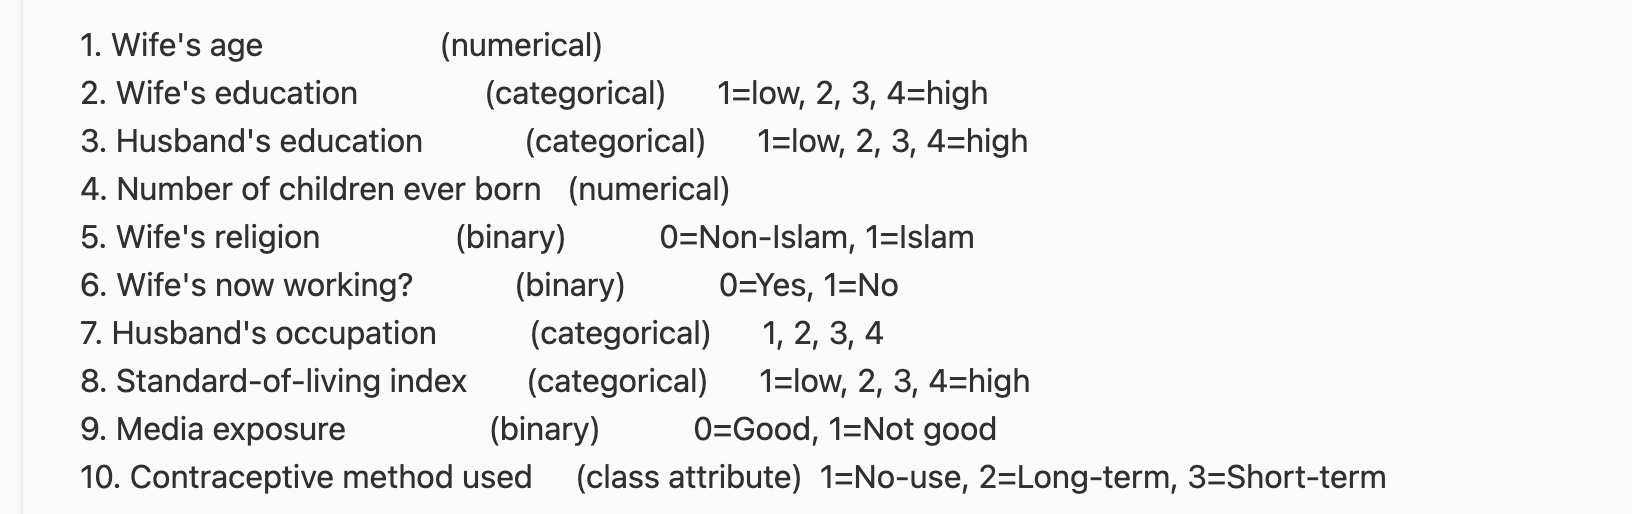

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo
contraceptive_method_choice = fetch_ucirepo(id=30)
X = contraceptive_method_choice.data.features
y = contraceptive_method_choice.data.targets
df_cmc = pd.concat([X, y], axis=1)

cls = df_cmc.columns[-1]

df_cmc.head()


,wife_age,wife_edu,husband_edu,num_children,wife_religion,wife_working,husband_occupation,standard_of_living_index,media_exposure,contraceptive_method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [ ]:
decision_tree_model, acc, encoders = run_decision_tree(
    df_cmc,
    cls=cls,
    test_size=0.2,
    max_depth=10,
    min_samples_for_nb=10,
    use_naive_bayes=False
)
print(f"Regular Decision Tree Accuracy: {acc * 100:.2f}%")

hybrid_tree_model, acc, encoders  = run_decision_tree(
    df_cmc,
    cls=cls,
    test_size=0.2,
    max_depth=10,
    use_naive_bayes=True,
    min_samples_for_nb=10,
    nb_threshold=0.1
)
print(f"Hybrid Decision Tree Accuracy: {acc * 100:.2f}%")

Regular Decision Tree Accuracy: 48.14%
Hybrid Decision Tree Accuracy: 53.90%


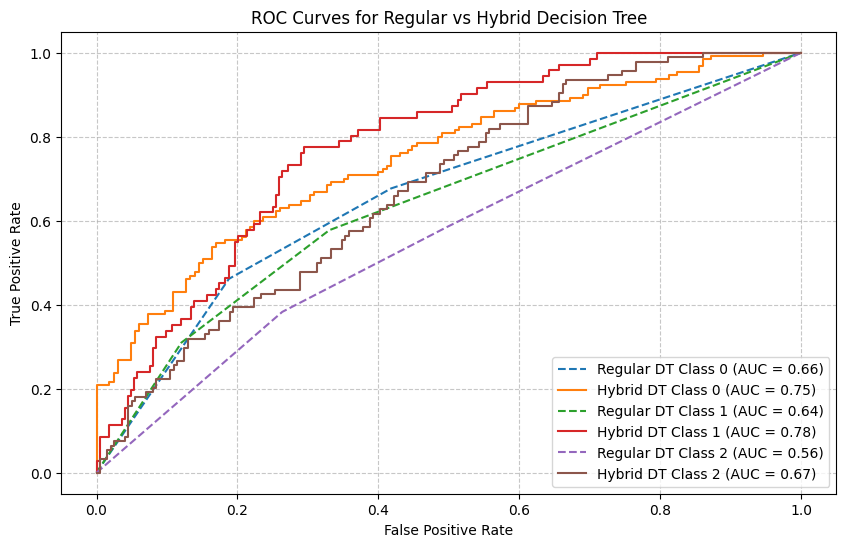

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

train_data, test_data = train_test_split(df_encoded, test_size=0.2, random_state=42)

y_true = test_data[cls].values
class_labels = np.unique(y_true)

y_true_bin = label_binarize(y_true, classes=class_labels)

y_scores_tree = []
for i, instance in test_data.iterrows():
    probs = predict_proba_tree(instance, decision_tree_model, class_labels)
    y_scores_tree.append(list(probs.values()))
y_scores_tree = np.array(y_scores_tree)

y_scores_hybrid = []
for i, instance in test_data.iterrows():
    probs = predict_proba_tree(instance, hybrid_tree_model, class_labels)
    y_scores_hybrid.append(list(probs.values()))
y_scores_hybrid = np.array(y_scores_hybrid)

plt.figure(figsize=(10, 6))
for i in range(y_true_bin.shape[1]):
    fpr_tree, tpr_tree, f = roc_curve(y_true_bin[:, i], y_scores_tree[:, i])
    roc_auc_tree = auc(fpr_tree, tpr_tree)

    fpr_hybrid, tpr_hybrid, f = roc_curve(y_true_bin[:, i], y_scores_hybrid[:, i])
    roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

    plt.plot(fpr_tree, tpr_tree, linestyle='--', label=f"Regular DT Class {i} (AUC = {roc_auc_tree:.2f})")
    plt.plot(fpr_hybrid, tpr_hybrid, linestyle='-', label=f"Hybrid DT Class {i} (AUC = {roc_auc_hybrid:.2f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Regular vs Hybrid Decision Tree")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


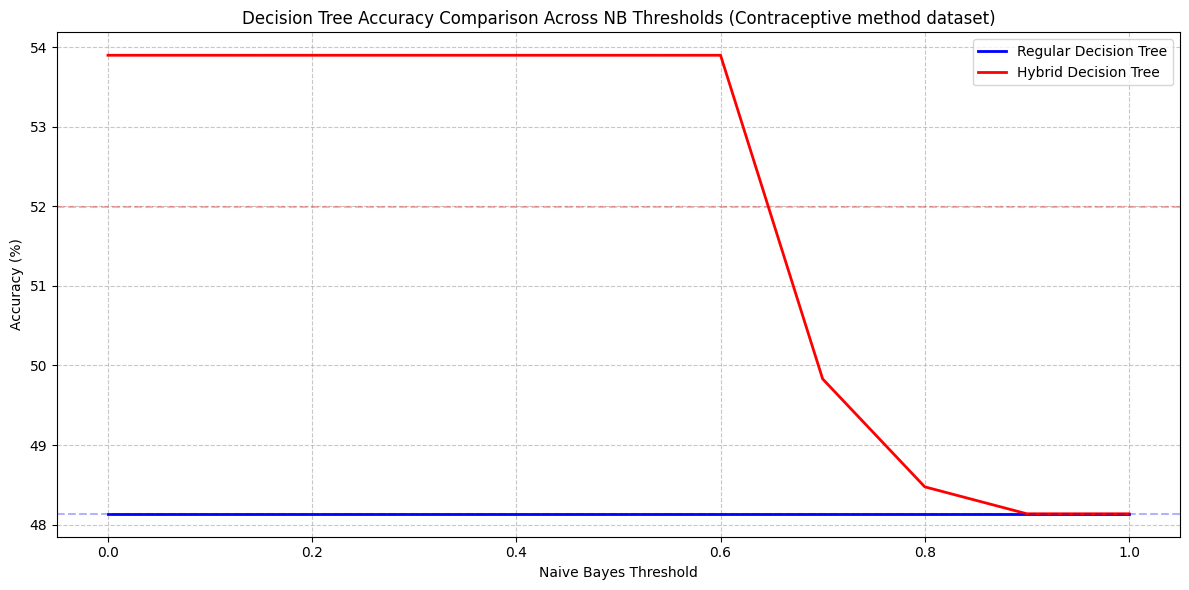


Summary Statistics:
Regular Decision Tree-Mean Accuracy: 48.14%
Hybrid Decision Tree-Mean Accuracy: 51.99%

Best Hybrid Performance:
Threshold: 0.00
Accuracy: 53.90%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#function to run experiments
def compare_accuracies(df, cls, thresholds,max_depth = 10, min_samples_for_nb = 10):
    regular_accuracies = []
    hybrid_accuracies = []

    for threshold in thresholds:
        #regular
        i, regular_acc, j = run_decision_tree(
            df,
            cls=cls,
            test_size=0.2,
            max_depth=10,
            min_samples_for_nb=10,
            use_naive_bayes=False
        )

        #hybrid
        i, hybrid_acc, j = run_decision_tree(
            df,
            cls=cls,
            test_size=0.2,
            max_depth=10,
            use_naive_bayes=True,
            min_samples_for_nb=10,
            nb_threshold=threshold
        )

        regular_accuracies.append(regular_acc * 100)
        hybrid_accuracies.append(hybrid_acc * 100)



    return regular_accuracies, hybrid_accuracies

thresholds = np.arange(0.0, 1.05, 0.1)

regular_accuracies, hybrid_accuracies = compare_accuracies(df_cmc, cls, thresholds)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, regular_accuracies, 'b-', label='Regular Decision Tree', linewidth=2)
plt.plot(thresholds, hybrid_accuracies, 'r-', label='Hybrid Decision Tree', linewidth=2)

plt.xlabel('Naive Bayes Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Decision Tree Accuracy Comparison Across NB Thresholds (Contraceptive method dataset)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.axhline(y=np.mean(regular_accuracies), color='b', linestyle='--', alpha=0.3)
plt.axhline(y=np.mean(hybrid_accuracies), color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSummary Statistics:")
print(f"Regular Decision Tree-Mean Accuracy: {np.mean(regular_accuracies):.2f}%")
print(f"Hybrid Decision Tree-Mean Accuracy: {np.mean(hybrid_accuracies):.2f}%")
print(f"\nBest Hybrid Performance:")
best_idx = np.argmax(hybrid_accuracies)
print(f"Threshold: {thresholds[best_idx]:.2f}")
print(f"Accuracy: {hybrid_accuracies[best_idx]:.2f}%")

# RUNNING ON SEABORN'S TITANIC DATASET

In [ ]:
import seaborn as sns
import pandas as pd

df_titanic = sns.load_dataset("titanic")
df_titanic = df_titanic[['sex', 'pclass', 'embarked', 'who', 'alone','survived']].dropna()
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in df_titanic.columns:
    df_titanic[col] = encoder.fit_transform(df_titanic[col])

df_titanic.head()


,sex,pclass,embarked,who,alone,survived
0,1,2,2,1,0,0
1,0,0,0,2,0,1
2,0,2,2,2,1,1
3,0,0,2,2,0,1
4,1,2,2,1,1,0


In [ ]:
from sklearn.metrics import accuracy_score


encoders = {col: LabelEncoder().fit(df_titanic[col]) for col in df_titanic.columns}
df_encoded = df_titanic.apply(lambda col: encoders[col.name].transform(col))

cls = 'survived'
decision_tree_model, acc, encoders = run_decision_tree(df_titanic, cls=cls, test_size=0.2, max_depth=3, use_naive_bayes=False)
print(f"Regular Decision Tree Accuracy: {acc * 100:.2f}%")

decision_tree_model, acc ,encoders= run_decision_tree(df_titanic, cls=cls, test_size=0.2, max_depth=3, min_samples_for_nb=10, use_naive_bayes=True, nb_threshold=.7)
print(f"Hybrid Decision Tree Accuracy: {acc * 100:.2f}%")





Regular Decision Tree Accuracy: 81.46%
Hybrid Decision Tree Accuracy: 80.90%


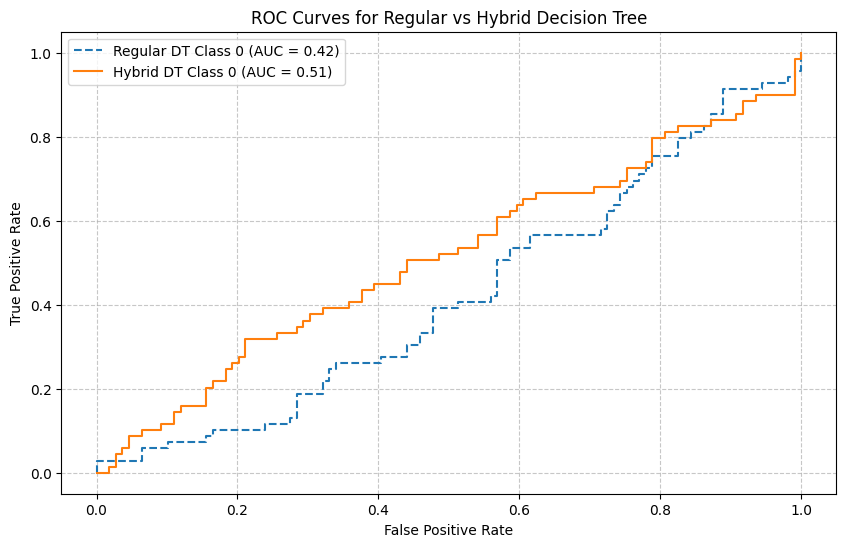

In [ ]:
y_true = test_data[cls].values
class_labels = np.unique(y_true)
y_true_bin = label_binarize(y_true, classes=class_labels)

y_scores_tree = []
for i, instance in test_data.iterrows():
    probs = predict_proba_tree(instance, decision_tree_model, class_labels)
    y_scores_tree.append(list(probs.values()))
y_scores_tree = np.array(y_scores_tree)

y_scores_hybrid = []
for i, instance in test_data.iterrows():
    probs = predict_proba_tree(instance, decision_tree_model, class_labels)
    y_scores_hybrid.append(list(probs.values()))
y_scores_hybrid = np.array(y_scores_hybrid)

plt.figure(figsize=(10, 6))
for i in range(y_true_bin.shape[1]):
    fpr_tree, tpr_tree, f = roc_curve(y_true_bin[:, i], y_scores_tree[:, i])
    roc_auc_tree = auc(fpr_tree, tpr_tree)

    fpr_hybrid, tpr_hybrid, _ = roc_curve(y_true_bin[:, i], y_scores_hybrid[:, i])
    roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

    plt.plot(fpr_tree, tpr_tree, linestyle='--', label=f"Regular DT Class {i} (AUC = {roc_auc_tree:.2f})")
    plt.plot(fpr_hybrid, tpr_hybrid, linestyle='-', label=f"Hybrid DT Class {i} (AUC = {roc_auc_hybrid:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Regular vs Hybrid Decision Tree")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# RUNNING ON UCI MUSHROOM DATASET

In [ ]:
from ucimlrepo import fetch_ucirepo

df_mushroom_ = fetch_ucirepo(id=73)


X = df_mushroom_.data.features
y = df_mushroom_.data.targets
df_mushroom = pd.concat([X, y], axis=1)

cls = df_mushroom.columns[-1]



In [ ]:
import pandas as pd
df_mushroom = df_mushroom.astype(str)
if 'stalk-root' in df_mushroom.columns:
  df_mushroom = df_mushroom.drop(columns=['stalk-root'])

df_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [ ]:
decision_tree_model, acc, ENCODERS = run_decision_tree(df_mushroom, cls=cls, test_size=0.2, max_depth=30, use_naive_bayes=False)
print(f"Regular Decision Tree Accuracy: {acc * 100:.2f}%")

decision_tree_model, acc ,ENCODERS= run_decision_tree(df_mushroom, cls=cls, test_size=0.2, max_depth=30, min_samples_for_nb=0, use_naive_bayes=True, nb_threshold=.8)
print(f"Hybrid Decision Tree Accuracy: {acc * 100:.2f}%")

Regular Decision Tree Accuracy: 100.00%
Hybrid Decision Tree Accuracy: 95.94%


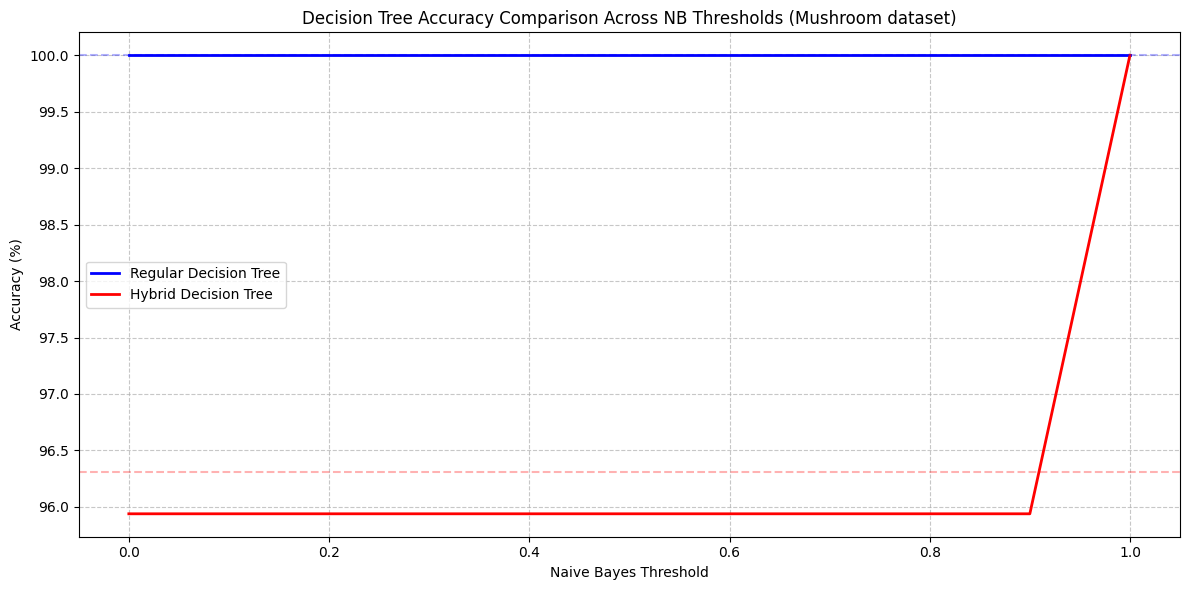


Summary Statistics:
Regular Decision Tree-Mean Accuracy: 100.00%
Hybrid Decision Tree-Mean Accuracy: 96.31%

Best Hybrid Performance:
Threshold: 1.00
Accuracy: 100.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


thresholds = np.arange(0.0, 1.05, 0.1)

regular_accuracies, hybrid_accuracies = compare_accuracies(df_mushroom, cls, thresholds, max_depth=50, min_samples_for_nb=2)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, regular_accuracies, 'b-', label='Regular Decision Tree', linewidth=2)
plt.plot(thresholds, hybrid_accuracies, 'r-', label='Hybrid Decision Tree', linewidth=2)

plt.xlabel('Naive Bayes Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Decision Tree Accuracy Comparison Across NB Thresholds (Mushroom dataset)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.axhline(y=np.mean(regular_accuracies), color='b', linestyle='--', alpha=0.3)
plt.axhline(y=np.mean(hybrid_accuracies), color='r', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSummary Statistics:")
print(f"Regular Decision Tree-Mean Accuracy: {np.mean(regular_accuracies):.2f}%")
print(f"Hybrid Decision Tree-Mean Accuracy: {np.mean(hybrid_accuracies):.2f}%")
print(f"\nBest Hybrid Performance:")
best_idx = np.argmax(hybrid_accuracies)
print(f"Threshold: {thresholds[best_idx]:.2f}")
print(f"Accuracy: {hybrid_accuracies[best_idx]:.2f}%")

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

y = LabelEncoder().fit_transform(y)

df_mnist = pd.concat([X, pd.Series(y, name='label')], axis=1)
cls = 'label'

decision_tree_model, acc, _ = run_decision_tree(df_mnist, cls=cls, test_size=0.2, max_depth=30, use_naive_bayes=True, nb_threshold=0.8)
print(f"Hybrid Decision Tree Accuracy: {acc * 100:.2f}%")


Hybrid Decision Tree Accuracy: 83.24%


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

y = LabelEncoder().fit_transform(y)

df_mnist = pd.concat([X, pd.Series(y, name='label')], axis=1)
cls = 'label'

decision_tree_model, acc, _ = run_decision_tree(df_mnist, cls=cls, test_size=0.2, max_depth=30, use_naive_bayes=False, nb_threshold=0.8)
print(f"Decision Tree Accuracy: {acc * 100:.2f}%")
